In [1]:
def is_running_in_colab():
    try:
        import google.colab
        !pip install nibabel nilearn dipy
        from google.colab import drive
        drive.mount('/content/drive')
        %pip install fslpy
        return True
    except ImportError:
        return False

In [2]:
%%capture
COLAB = is_running_in_colab()

In [3]:
import os
import os.path as op
from tqdm.notebook import trange, tqdm
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from IPython.display import Image

%matplotlib inline

In [4]:
if not COLAB:
  username = os.getlogin()
  data_path = "./data/" if "nicolas" in username else "/home/jovyan/Data"
else:
  data_path = "/content/drive/MyDrive/NSSP/data/"
dataset_id = "ds000171"
subject_id = "sub-control01"
fmri_path = op.join(data_path, dataset_id, "derivatives" , "preprocessed_data", subject_id, "func" ,f"{subject_id}_task-music_concat_bold_moco_bbr_std_smoothed-6mm.nii.gz")
anat_path = op.join(data_path, dataset_id, "derivatives" , "preprocessed_data", subject_id, "anat" ,f"{subject_id}_T1w_mni.nii.gz")
betted_mni_path = op.join(data_path, dataset_id, "derivatives" , "preprocessed_data", subject_id, "anat" ,f"{subject_id}_T1w_mni_mask.nii.gz")
gm_mask_path = op.join(data_path, dataset_id, "derivatives" , "preprocessed_data", subject_id, "anat" ,f"{subject_id}_T1w_fast_pve_1.nii.gz")


In [5]:
T1w_img = nib.load(anat_path)
gm_mask_img = nib.load(gm_mask_path)
clean_mask = nib.Nifti1Image((gm_mask_img.get_fdata()>=0.01).astype(int),gm_mask_img.affine, gm_mask_img.header)


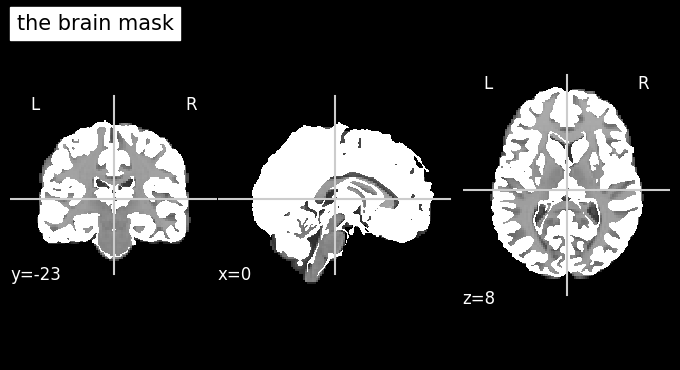

In [6]:
plot_stat_map(clean_mask, black_bg=True, title='the brain mask', colorbar=False,)

In [7]:
img = nib.load(fmri_path)

In [8]:
samples = img.get_fdata()
del img
samples.shape

(182, 218, 182, 315)

In [9]:
mask = clean_mask.get_fdata().astype(bool)

In [10]:
mask_first = True


In [11]:
v_shape = samples.shape

In [12]:
if mask_first:
  samples = samples[mask,:]
else:
  samples = samples[...,:105].reshape(-1, 105)
samples.shape

(1245458, 315)

## 22 components

In [13]:
### YOUR CODE HERE
from sklearn.decomposition import FastICA
ica_comp = 22
## First: use ICA on the SPATIAL axis
icas = FastICA(n_components=ica_comp, random_state=9)
icasig_space = icas.fit_transform(samples)  # Spatial source signals

## Then apply again ICA but on the temporal axis
icat = FastICA(n_components=ica_comp, random_state=9) #, random_state=9
icasig_time = icat.fit_transform(samples.T)  # Temporal source signals

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [14]:
if mask_first :
  icasig_space_r = np.zeros((v_shape[0], v_shape[1], v_shape[2], ica_comp)) # List of spatial components (you should have in the list volumes)
  icasig_space_r[mask,:] = icasig_space
else:
  new_shape = (v_shape[0], v_shape[1], v_shape[2], ica_comp)
  icasig_space_r = icasig_space.reshape(new_shape)

/usr/local/lib/python3.10/dist-packages/nilearn/plotting/displays/_slicers.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(figure, figsize=figsize, facecolor=facecolor)


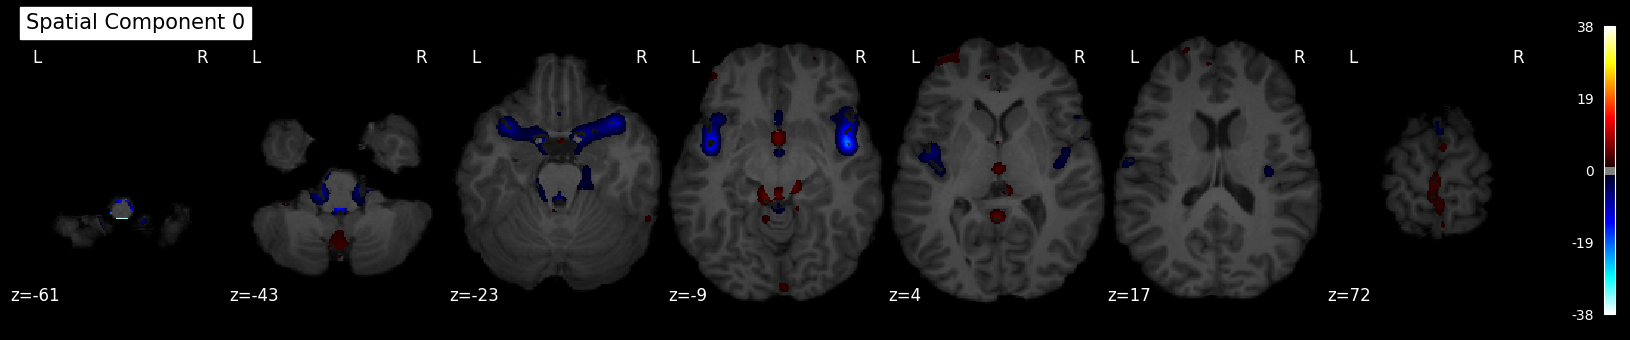

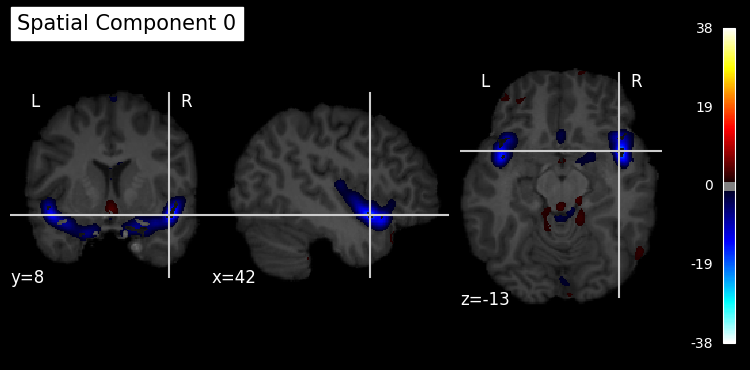

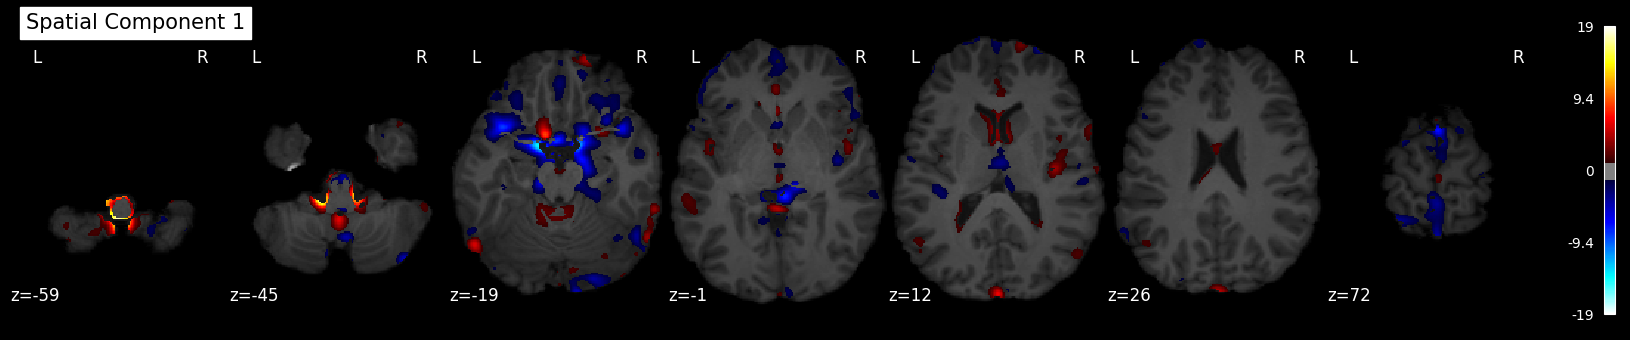

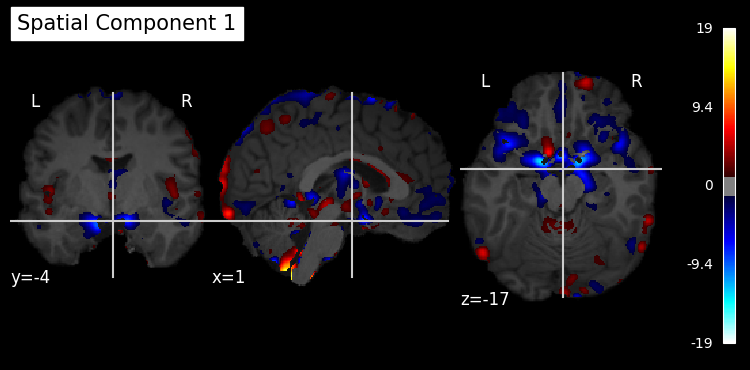

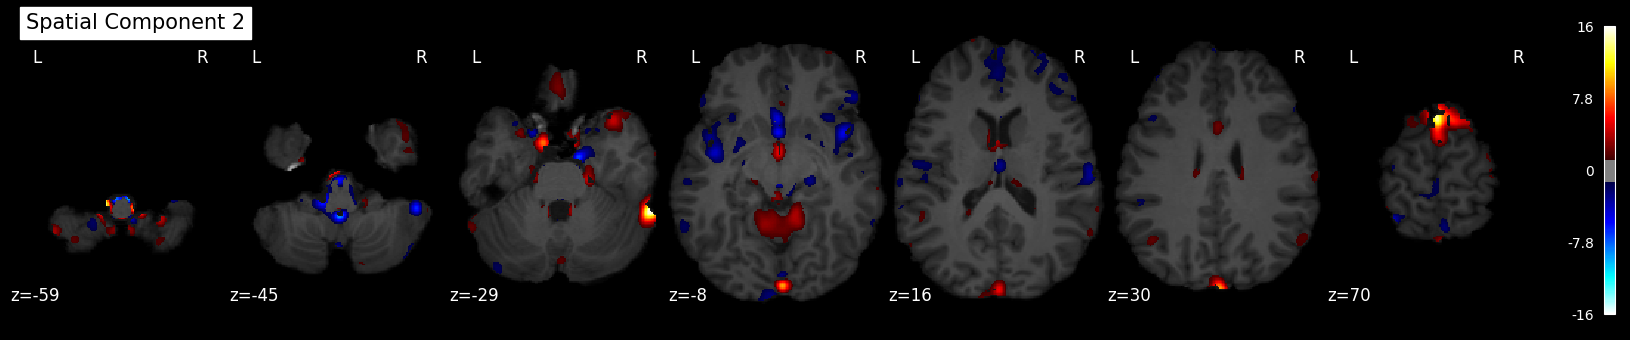

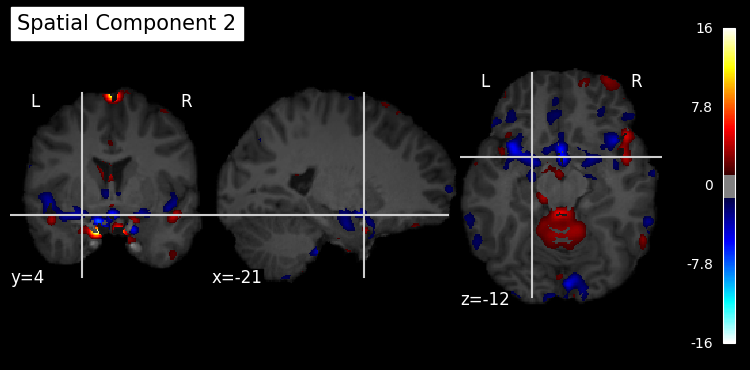

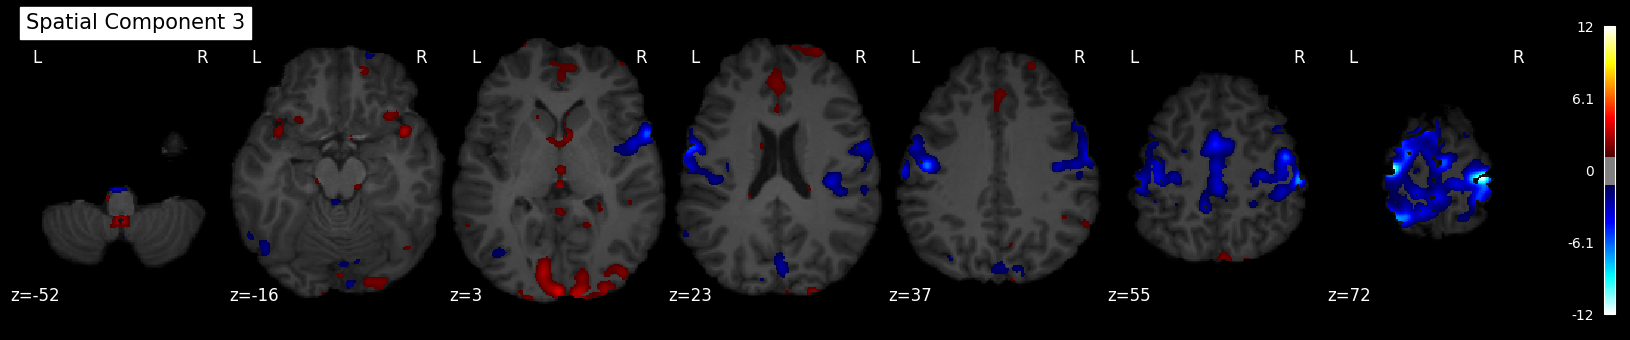

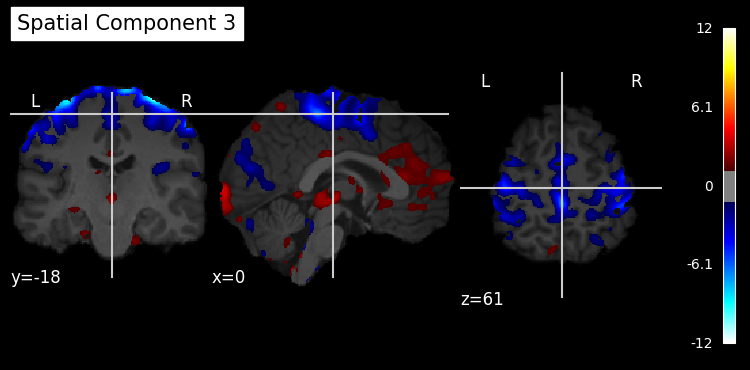

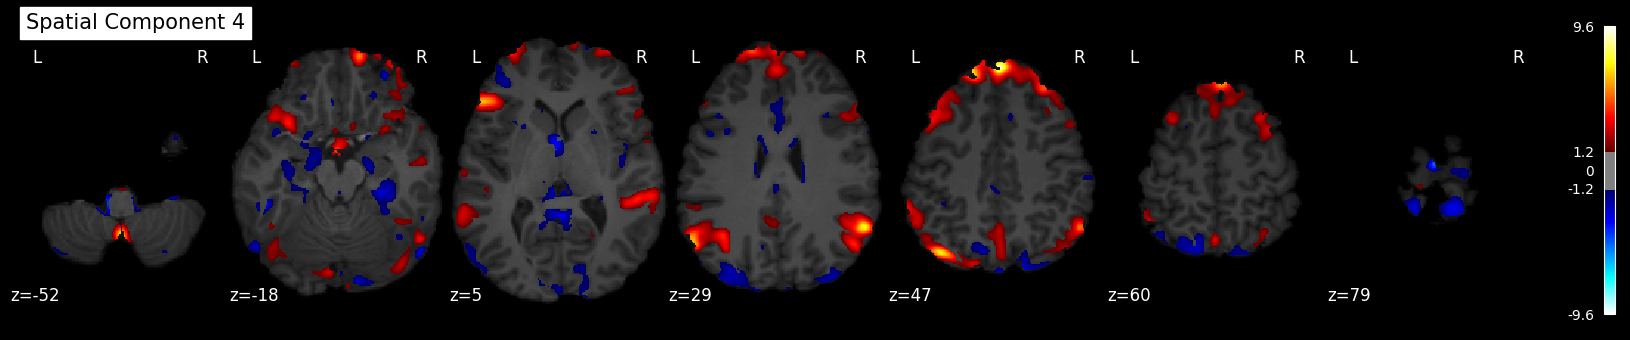

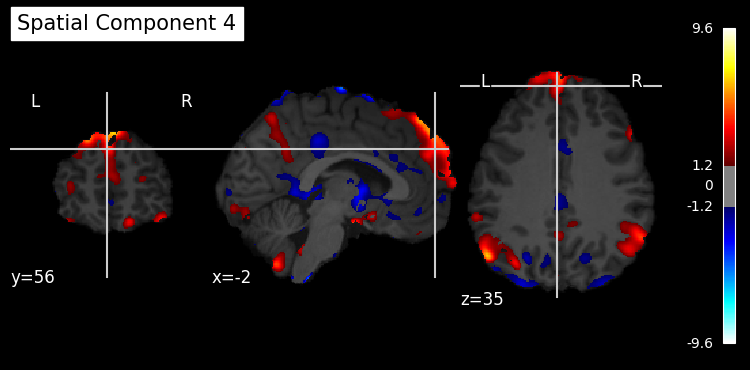

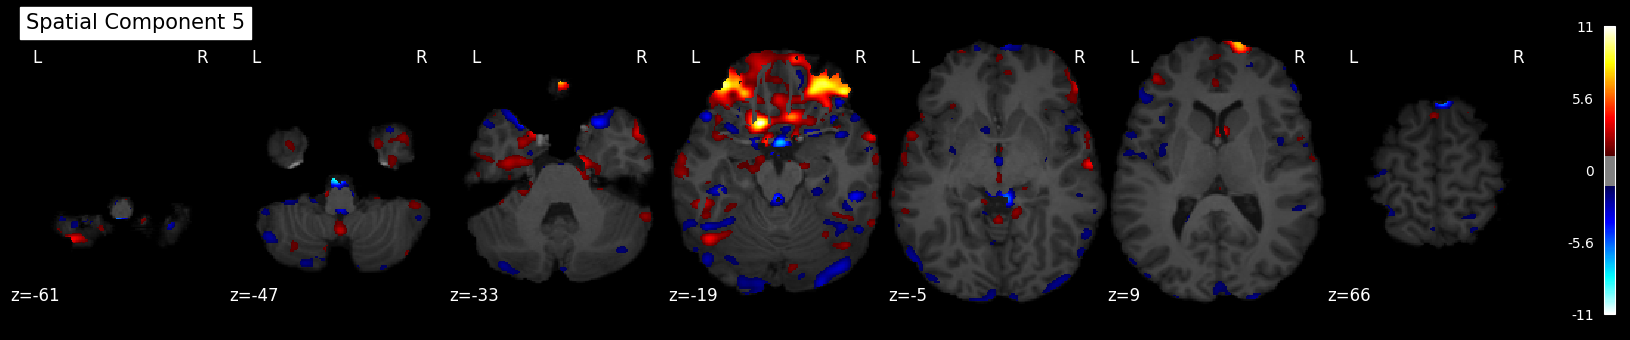

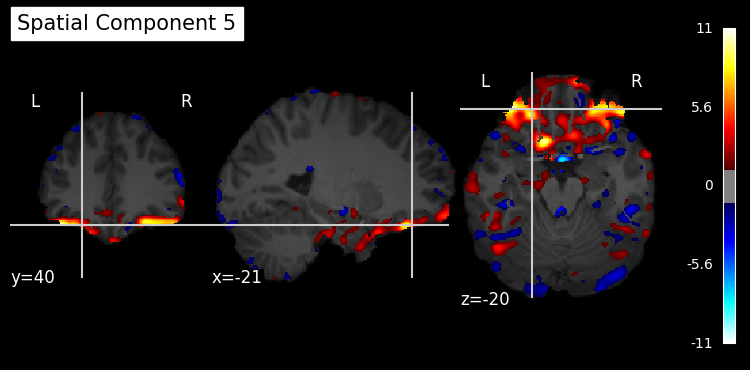

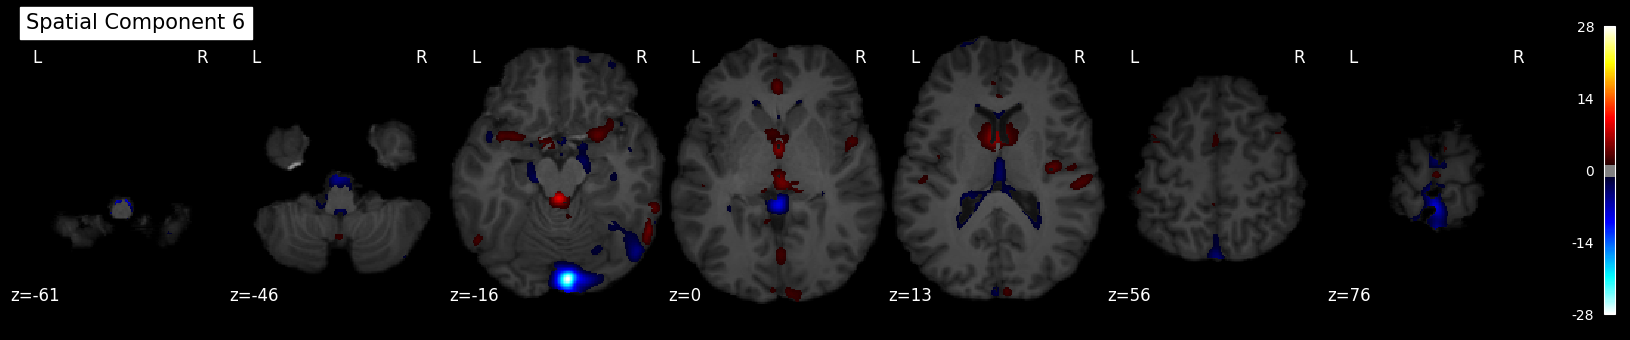

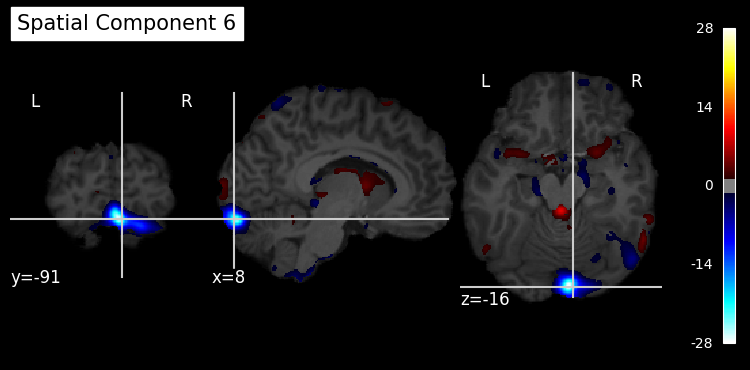

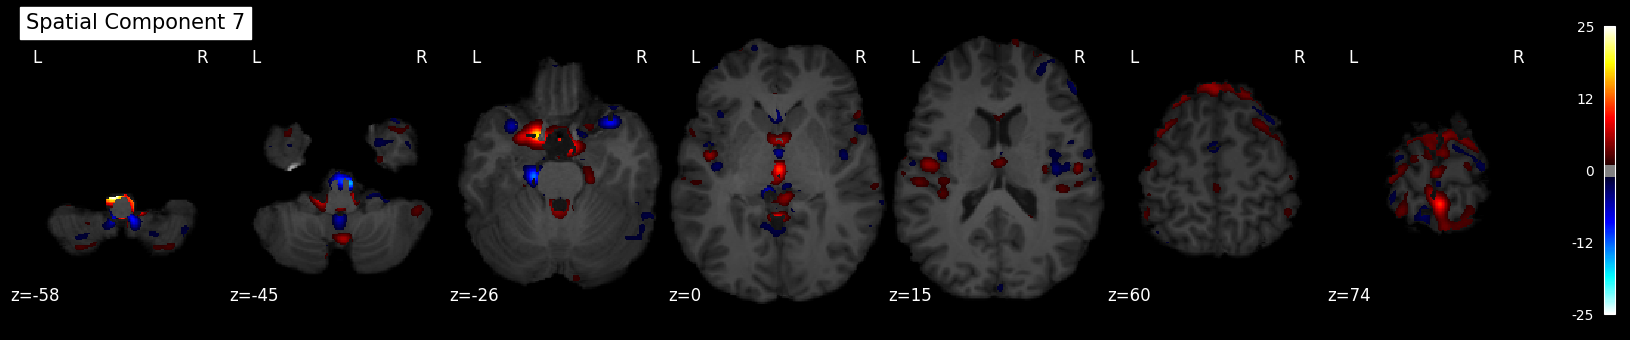

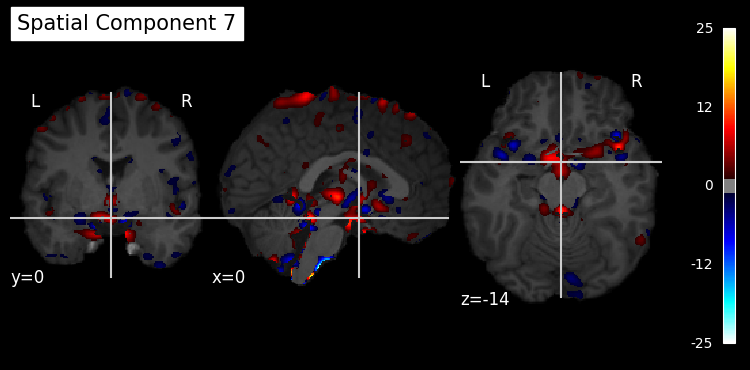

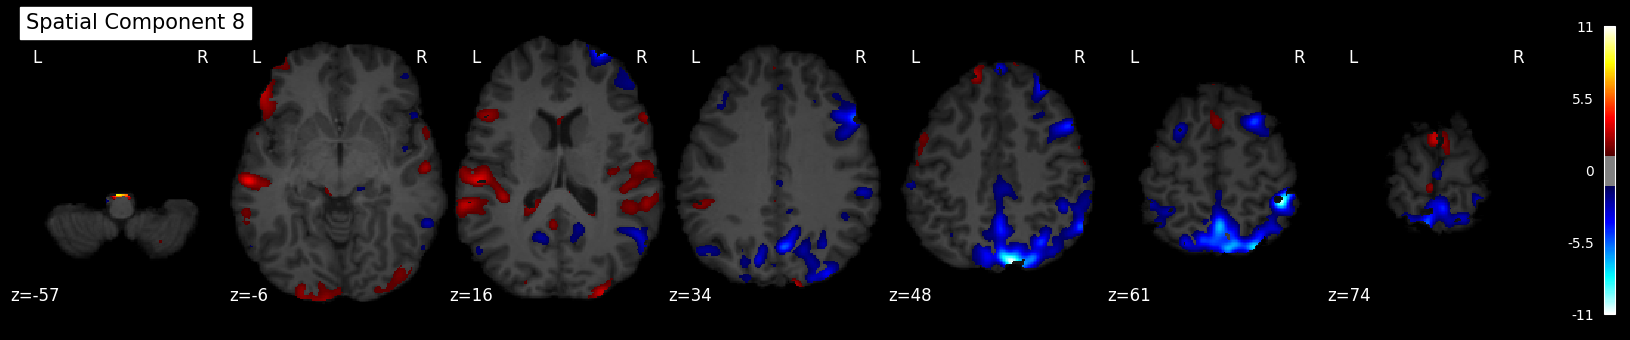

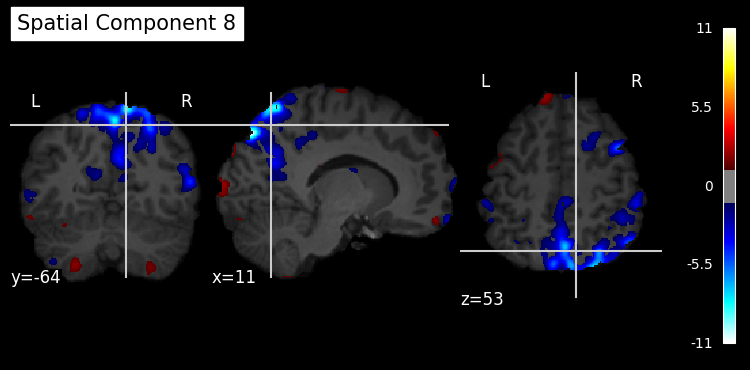

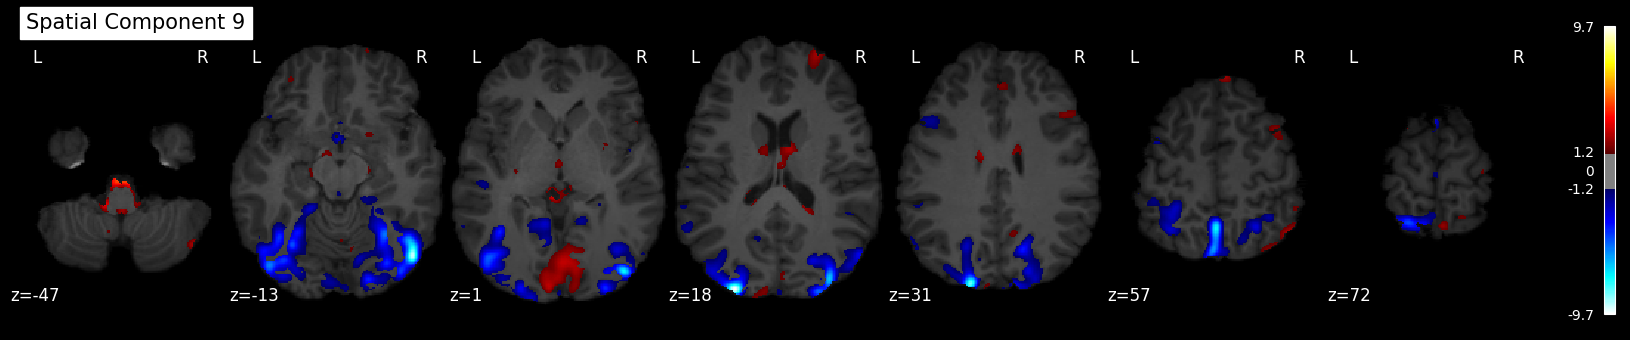

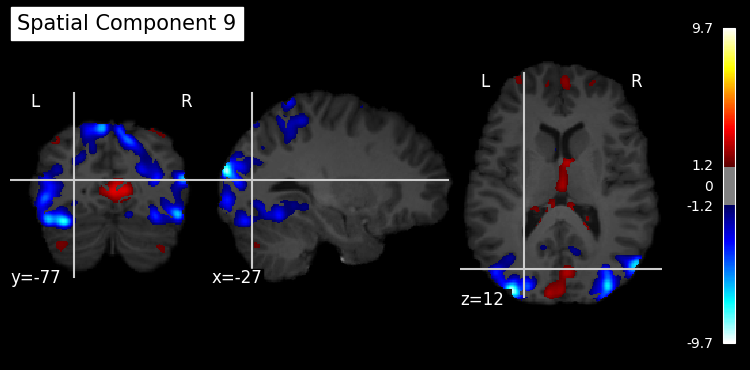

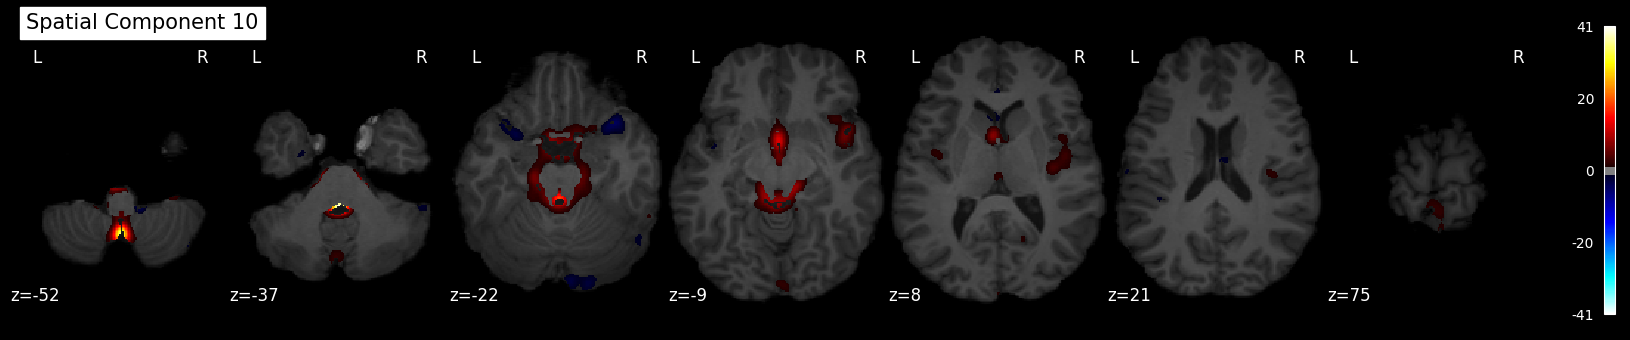

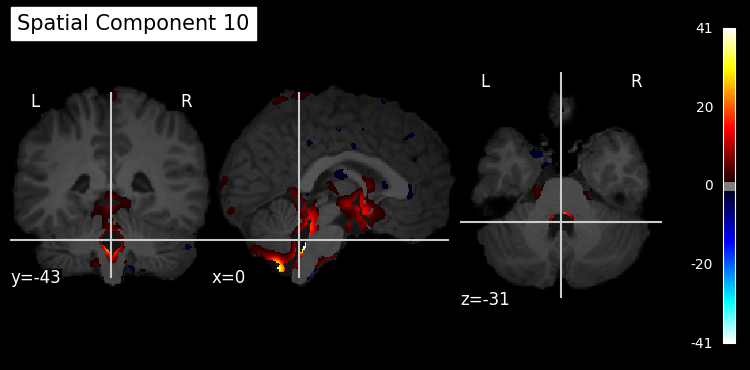

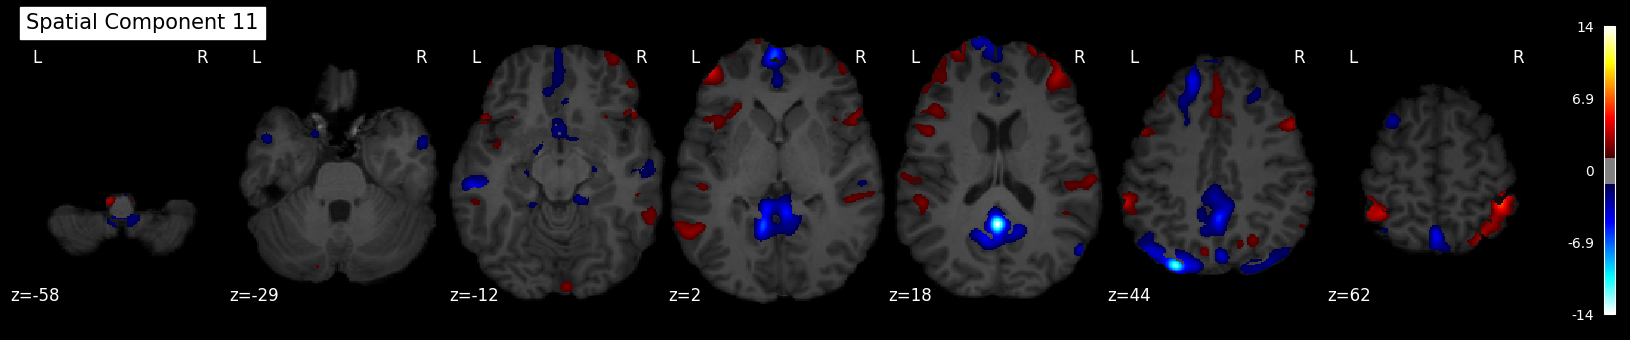

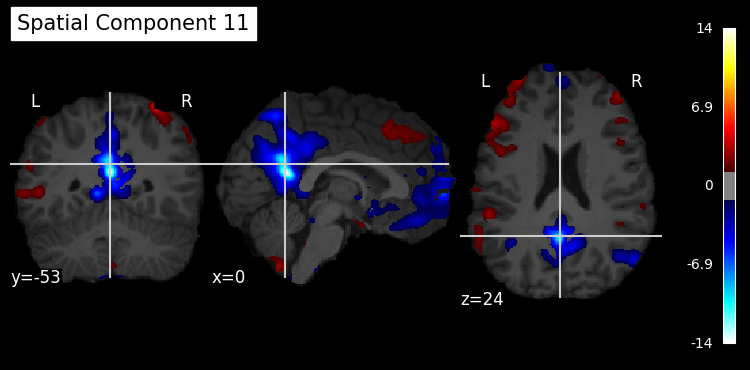

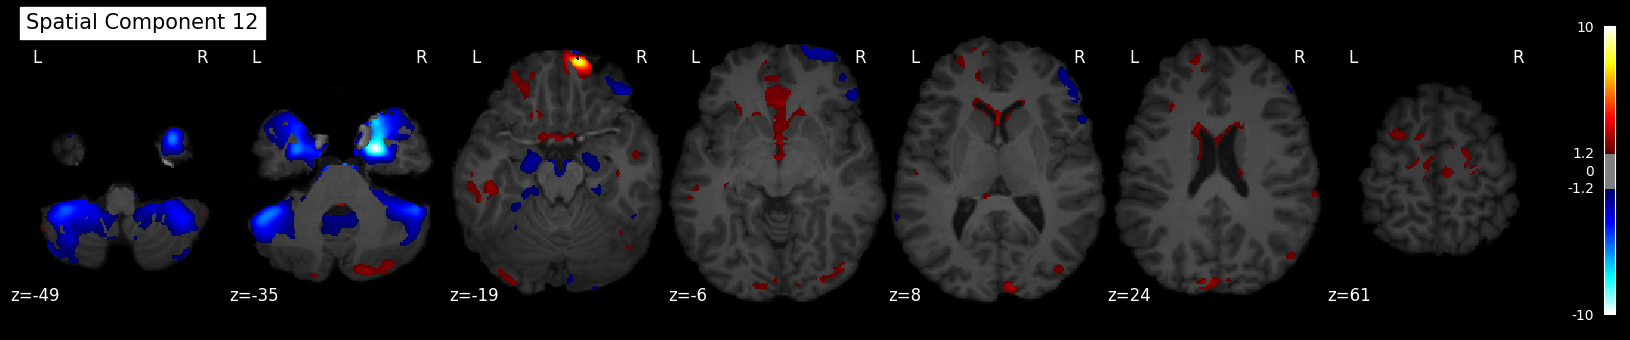

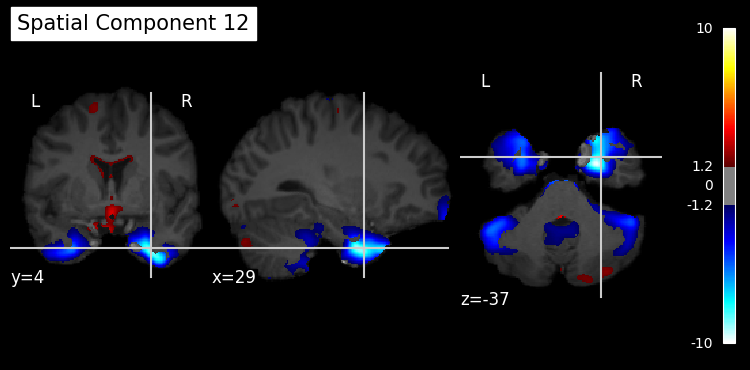

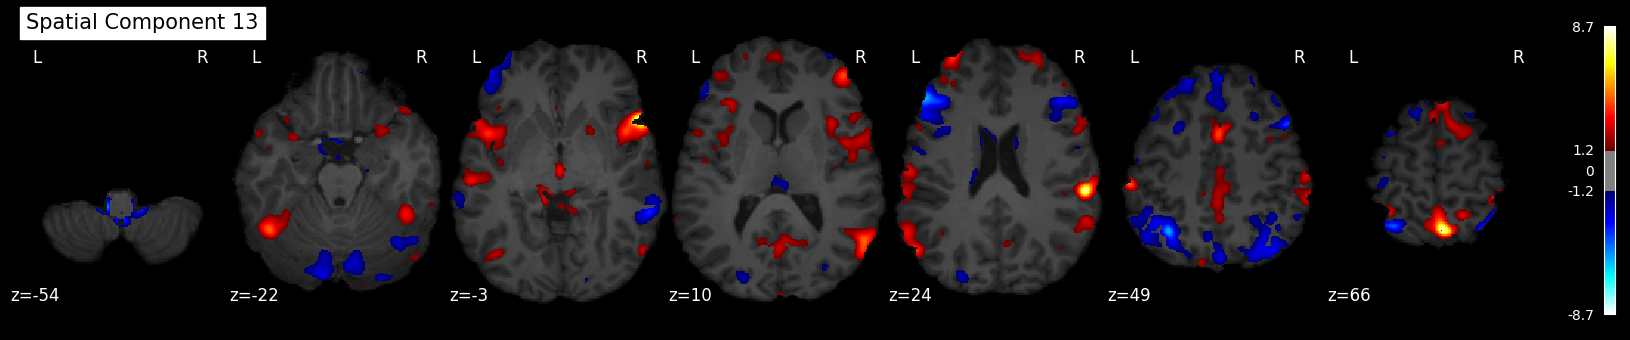

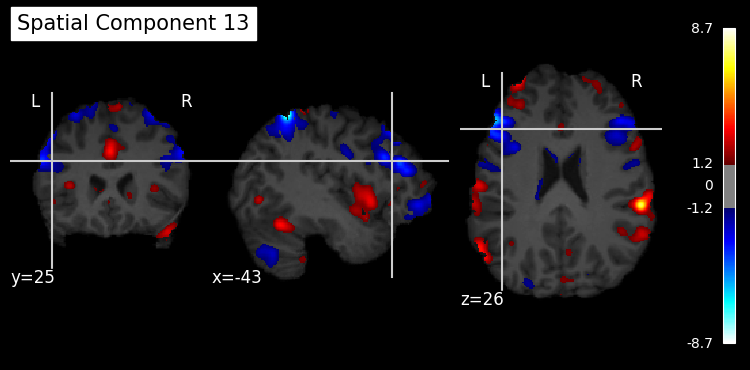

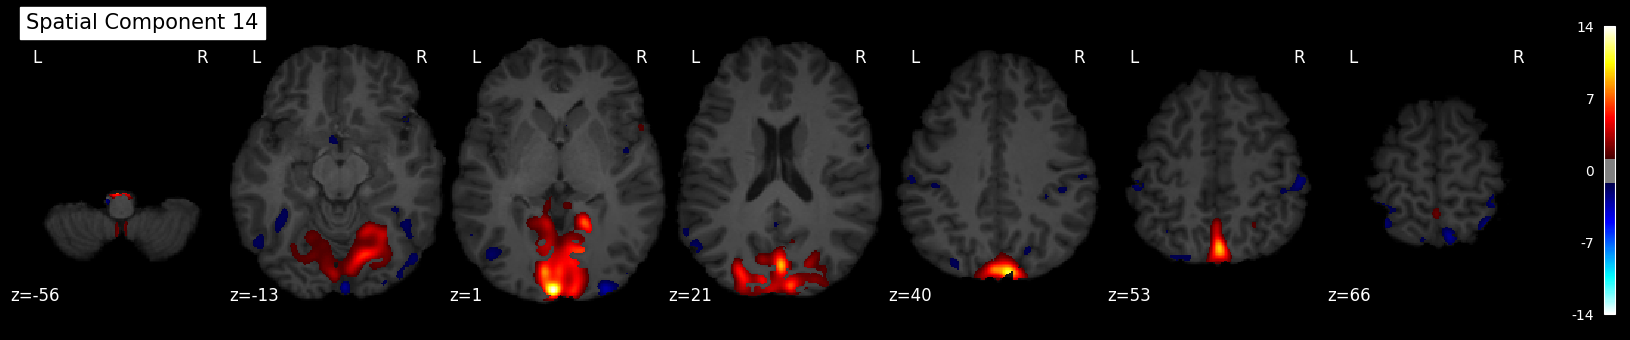

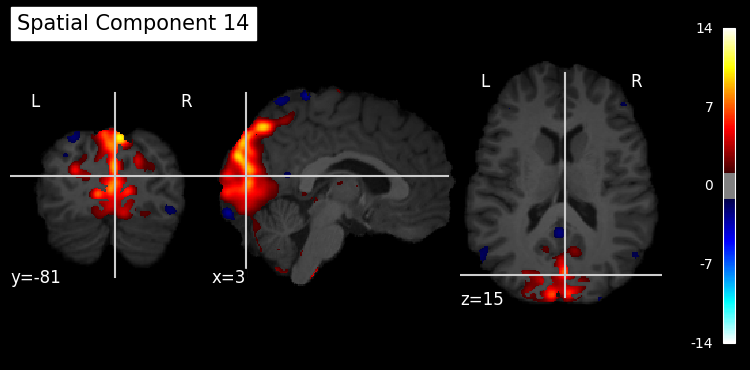

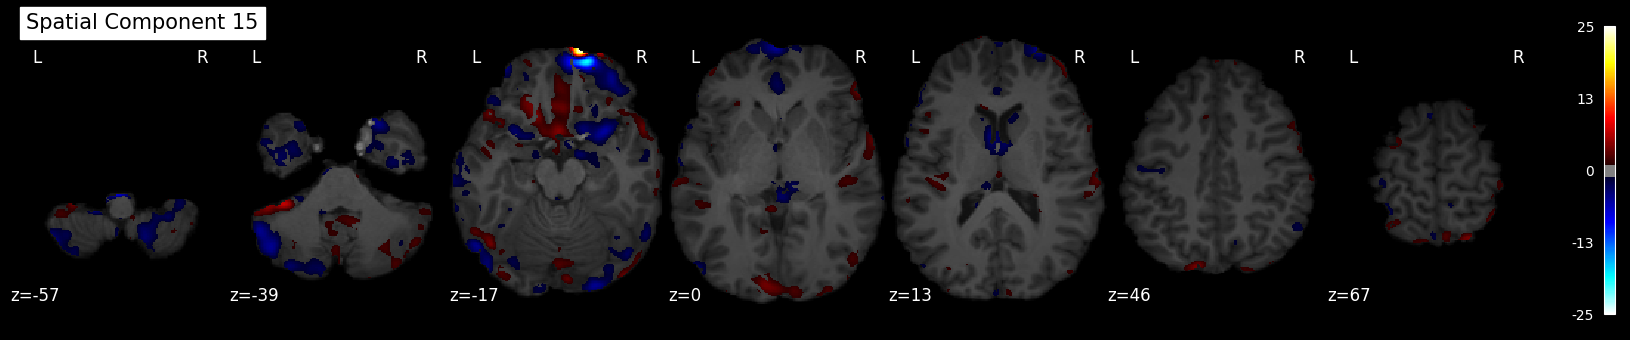

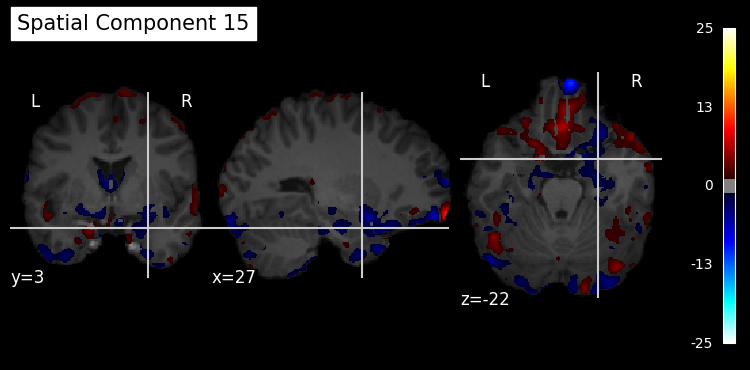

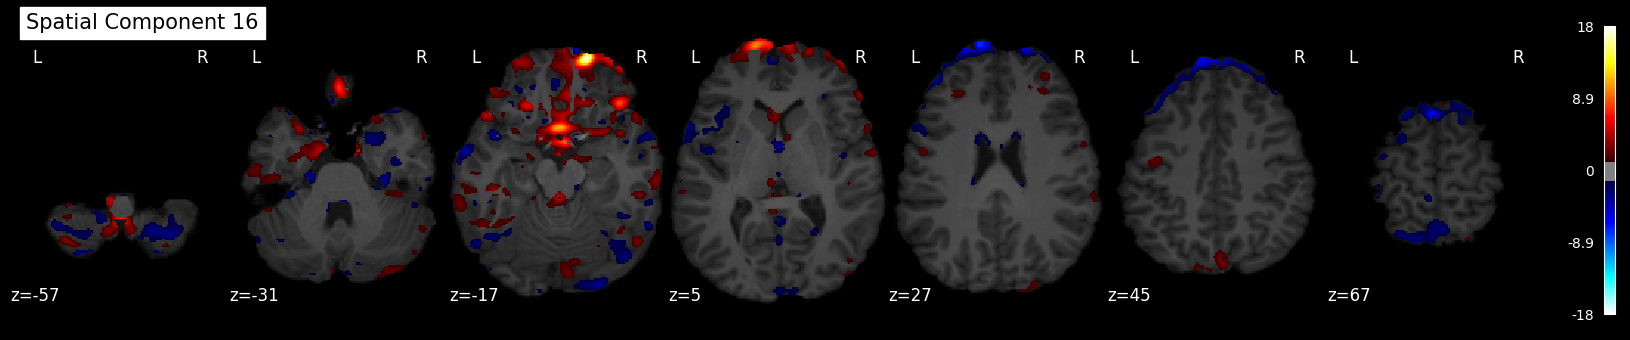

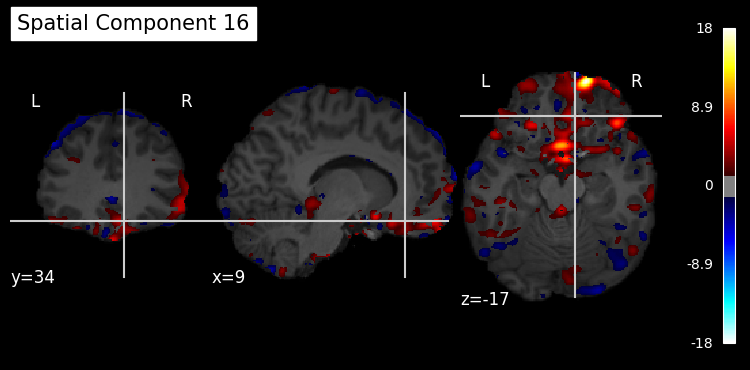

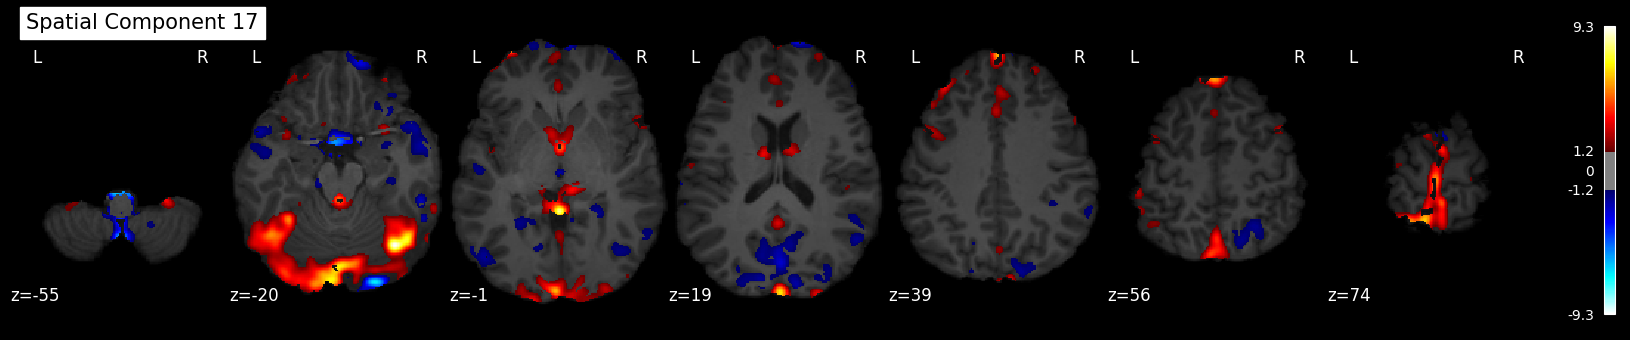

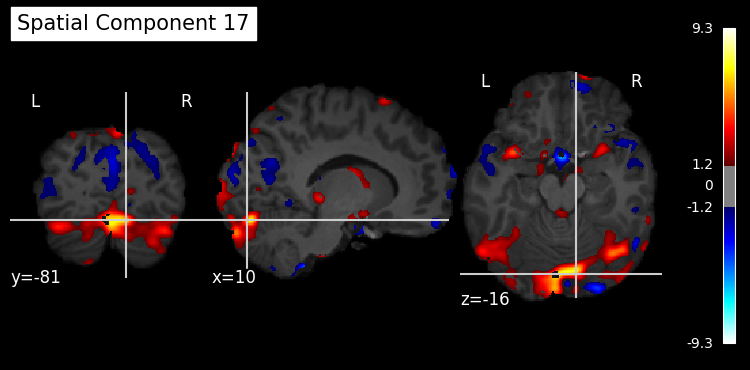

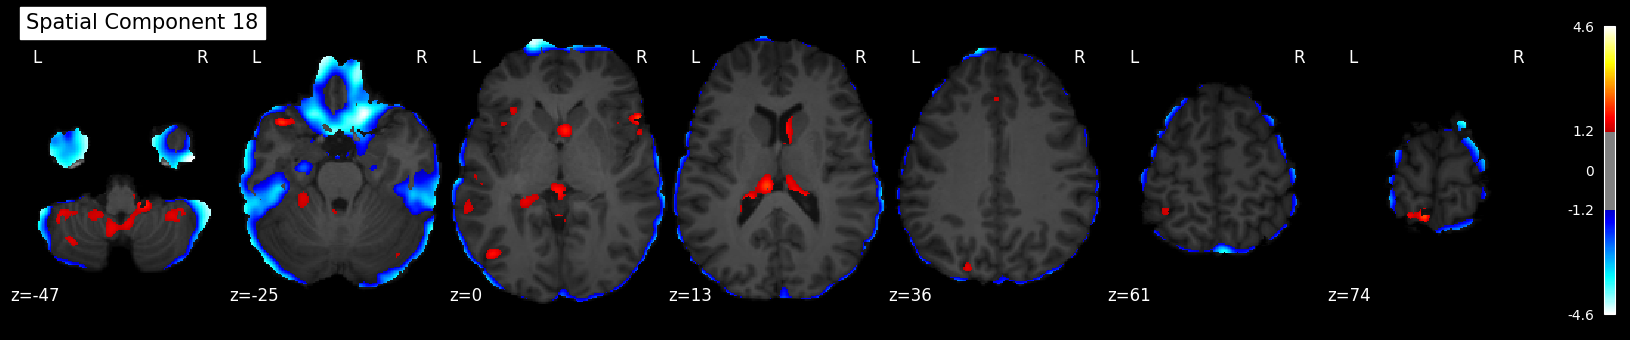

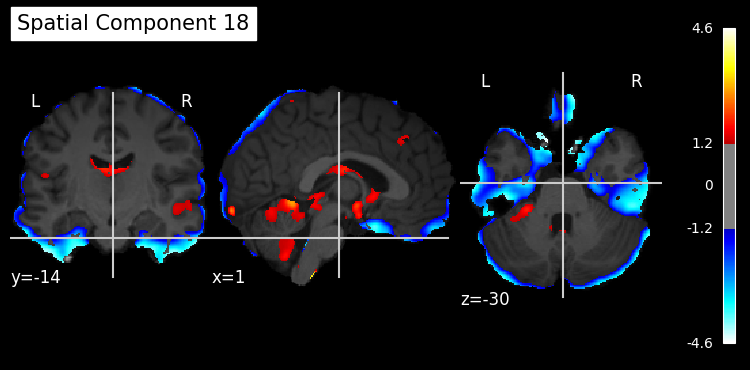

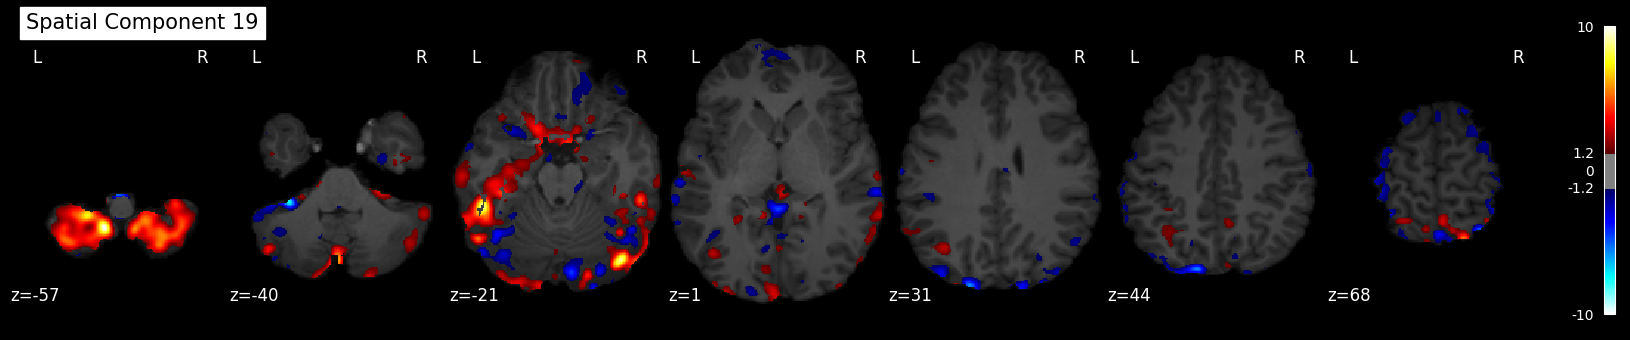

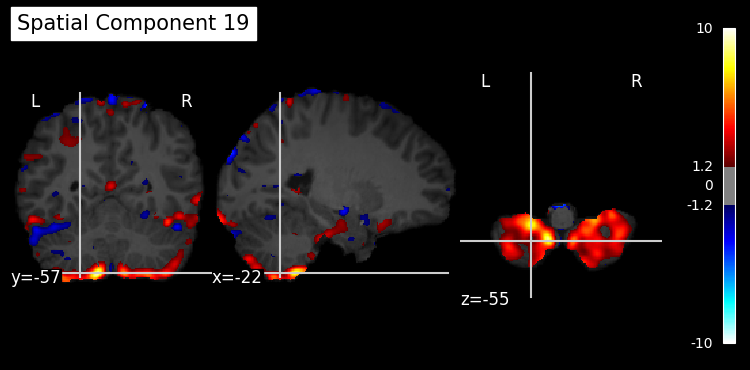

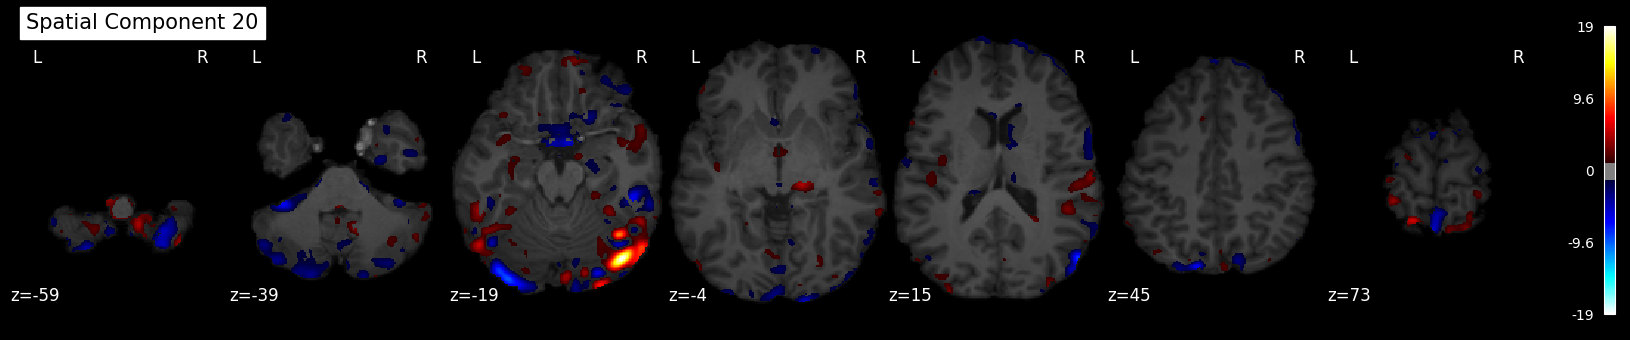

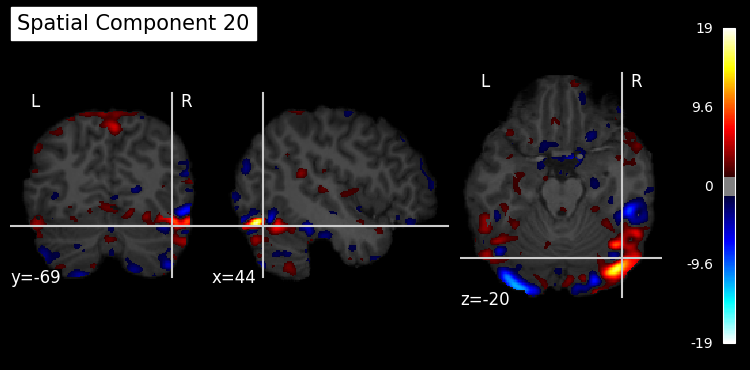

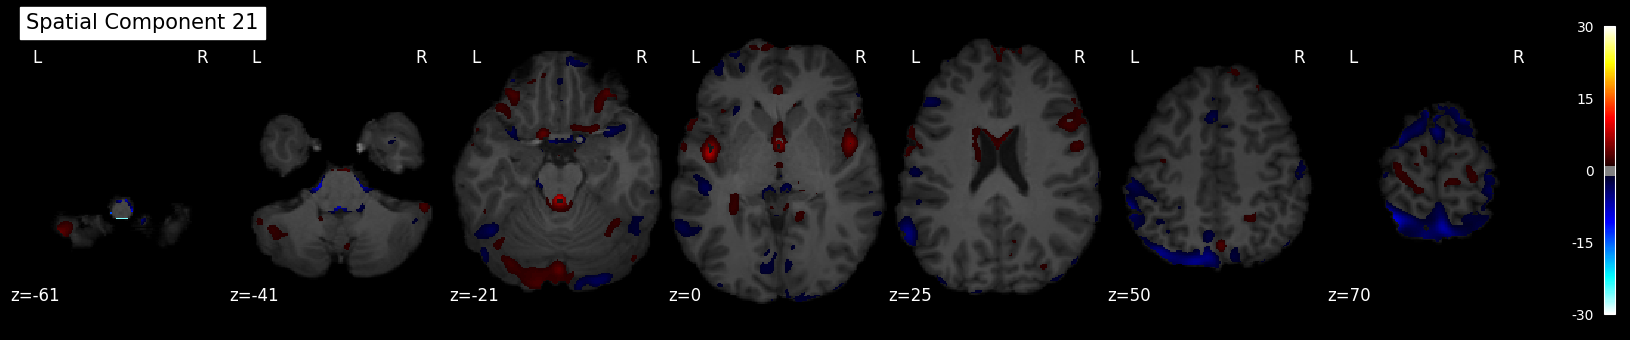

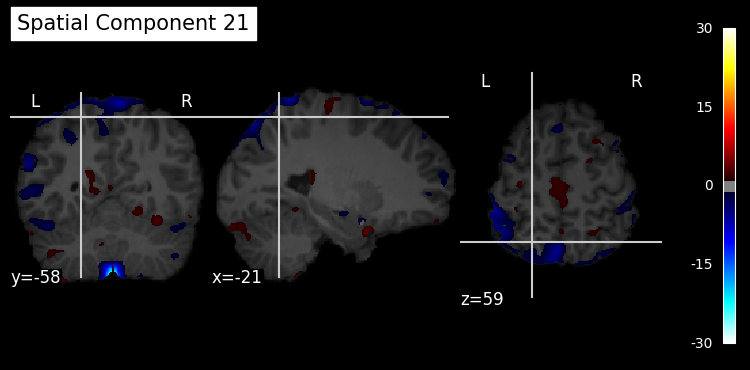

In [36]:
desired_views = ['z', 'ortho']
for c in range(ica_comp):
  img = nib.Nifti1Image(icasig_space_r[...,c], T1w_img.affine)

  for view_ in desired_views:
    plot_stat_map(img, display_mode=view_, title=f'Spatial Component {c}',
                  colorbar=True, black_bg=True, bg_img=T1w_img, threshold=3*np.std(icasig_space_r[...,c]),)

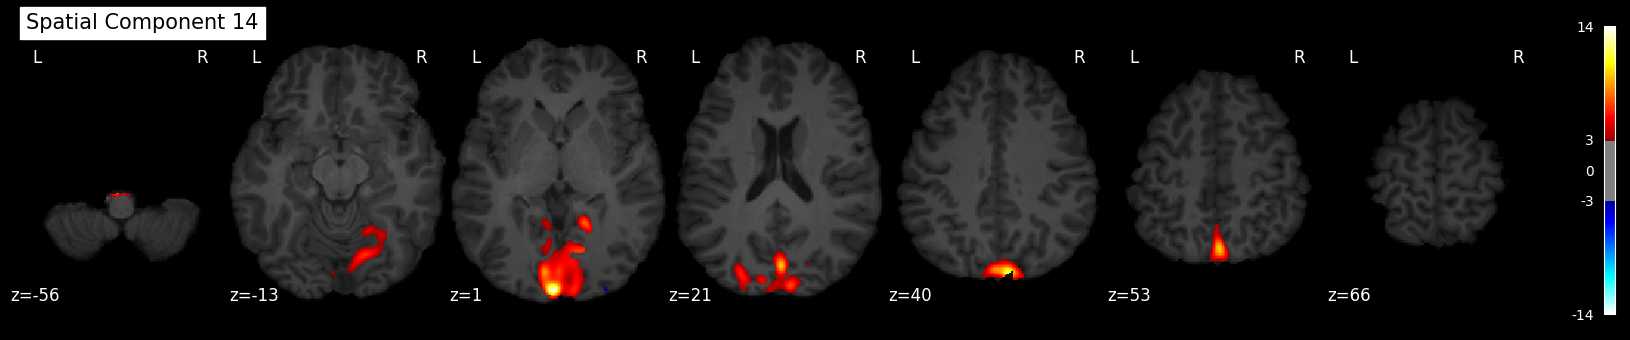

In [20]:
c = 14
img = nib.Nifti1Image(icasig_space_r[...,c], T1w_img.affine)

plot_stat_map(img, display_mode="z", title=f'Spatial Component {c}',
              colorbar=True, black_bg=True, bg_img=T1w_img, threshold=3,)

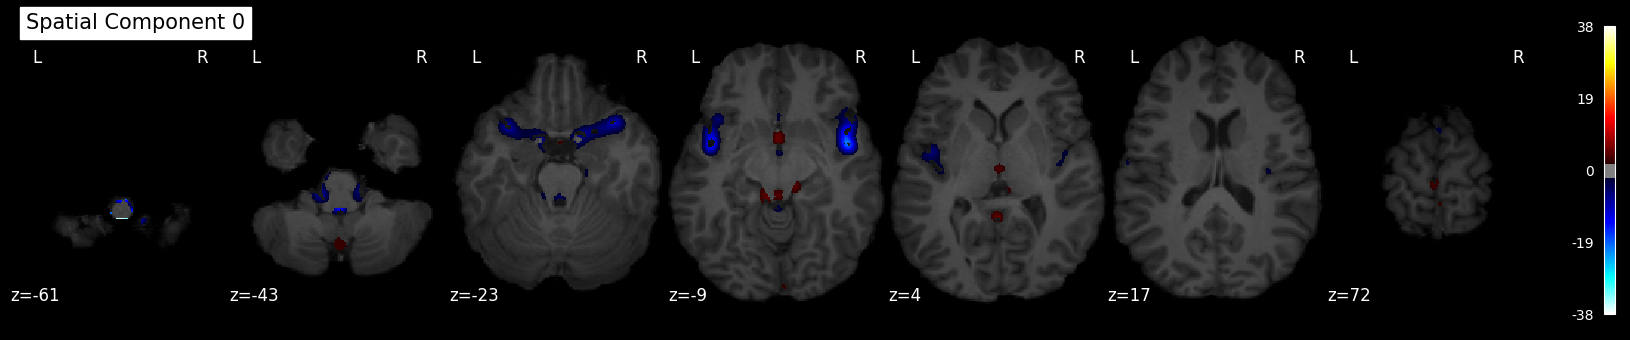

In [22]:
c = 0
img = nib.Nifti1Image(icasig_space_r[...,c], T1w_img.affine)

plot_stat_map(img, display_mode="z", title=f'Spatial Component {c}',
              colorbar=True, black_bg=True, bg_img=T1w_img, threshold=2,)

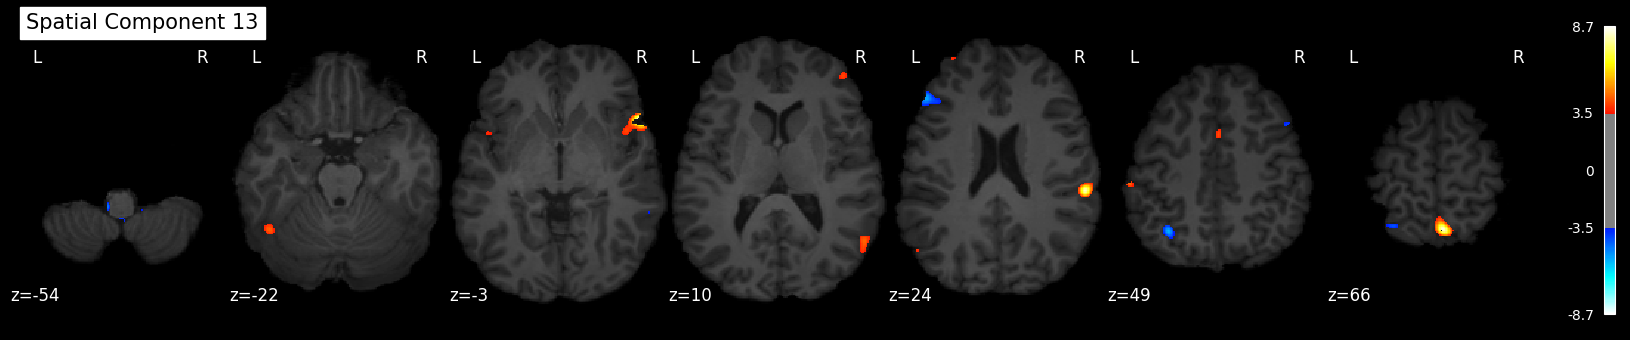

In [41]:
c = 13
img = nib.Nifti1Image(icasig_space_r[...,c], T1w_img.affine)

plot_stat_map(img, display_mode="z", title=f'Spatial Component {c}',
              colorbar=True, black_bg=True, bg_img=T1w_img, threshold=3.5,)